# Tennis Court Key Points CV

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

In [202]:
def binary_image(image, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]

def find_lines(image, threshold, min_line_length, max_line_gap):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return np.squeeze(lines)

def find_intersections(lines):
  intersections = []
  # check intersection of each pair of lines
  for i in range(len(lines)):
    for j in range(i+1, len(lines)):
      x1, y1, x2, y2 = lines[i]
      A1, B1, C1 = line_equation(x1, y1, x2, y2)

      x3, y3, x4, y4 = lines[j]
      A2, B2, C2 = line_equation(x3, y3, x4, y4)

      det = A1 * B2 - A2 * B1
      if det != 0:  # lines are not parallel
        x = (C1 * B2 - C2 * B1) / det
        y = (A1 * C2 - A2 * C1) / det

        if is_on_line(x, y, x1, y1, x2, y2) or is_on_line(x, y, x3, y3, x4, y4):
          intersections.append((int(x), int(y)))

  return np.array(intersections)

def line_equation(x1, y1, x2, y2):
  A = y2 - y1
  B = x1 - x2
  C = A * x1 + B * y1
  return A, B, C

def is_on_line(px, py, x1, y1, x2, y2):
  return min(x1, x2) <= px <= max(x1, x2) and min(y1, y2) <= py <= max(y1, y2)

def remove_neighbors_intersections(intersections, min_distance):
  if len(intersections) == 0: # No intersections to filter
    return intersections
  filtered = []
  for i, (x1, y1) in enumerate(intersections):
    keep = True
    for (x2, y2) in filtered:
      if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) < min_distance:
        keep = False
        break  # Stop checking if a close one is found
    if keep:
      filtered.append((x1, y1))
  return np.array(filtered)


class CourtLineIntersections():
  def __init__(self):
    pass

  def get_intersections(self, image,  binary_threshold=200 ,line_threshold=200, min_line_length=100, max_line_gap=5):
    binary = binary_image(image, binary_threshold)
    lines = find_lines(binary, line_threshold, min_line_length, max_line_gap)
    intersections = find_intersections(lines)
    intersections = remove_neighbors_intersections(intersections, 10)
    return intersections

  def updated_keypoint_location_to_intersection(keypoints, intersections, min_distance):
    if len(intersections) == 0 or len(keypoints) == 0:
      return keypoints  # no intersections or no keypoints

    updated_keypoints = keypoints.copy()
    tree = cKDTree(intersections)
    distances, indices = tree.query(keypoints)
    for i, (dist, idx) in enumerate(zip(distances, indices)):
      if dist < min_distance:
        updated_keypoints[i] = intersections[idx]
    return updated_keypoints

  def drow_intersections(self, image, intersections):
    for x, y in intersections:
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)

In [11]:
import cv2
import numpy as np
from scipy.spatial import cKDTree

class CourtLineIntersections():
 def __init__(self, binary_threshold=200, line_threshold=200, min_line_length=100, max_line_gap=5, min_distance=10):
  self.binary_threshold = binary_threshold
  self.line_threshold = line_threshold
  self.min_line_length = min_line_length
  self.max_line_gap = max_line_gap
  self.min_distance = min_distance

 def get_intersections(self, image):
  binary = self._binary_image(image)
  lines = self._find_lines(binary)
  intersections = self._find_intersections(lines)
  return self._remove_neighbors_intersections(intersections)

 def update_keypoint_location_to_intersection(self, keypoints, intersections):  # check intersection of each pair of lines
  if len(intersections) == 0 or len(keypoints) == 0:
   return keypoints

  updated_keypoints = keypoints.copy()
  tree = cKDTree(intersections)
  distances, indices = tree.query(keypoints)
  for i, (dist, idx) in enumerate(zip(distances, indices)):
   if dist < self.min_distance:
    updated_keypoints[i] = intersections[idx]
  return updated_keypoints

 def draw_intersections(self, image, intersections):
  for x, y in intersections:
   cv2.circle(image, (x, y), 5, (0, 0, 255), -1)

 def _binary_image(self, image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(gray, self.binary_threshold, 255, cv2.THRESH_BINARY)[1]

 def _find_lines(self, binary_image):
  lines = cv2.HoughLinesP(binary_image, 1, np.pi / 180, self.line_threshold,
                          minLineLength=self.min_line_length, maxLineGap=self.max_line_gap)
  return np.squeeze(lines) if lines is not None else np.array([])

 def _find_intersections(self, lines):
  intersections = []
  for i in range(len(lines)):
   for j in range(i + 1, len(lines)):
    x1, y1, x2, y2 = lines[i]
    x3, y3, x4, y4 = lines[j]
    A1, B1, C1 = self._line_equation(x1, y1, x2, y2)
    A2, B2, C2 = self._line_equation(x3, y3, x4, y4)

    det = A1 * B2 - A2 * B1
    if det != 0:
     x = (C1 * B2 - C2 * B1) / det
     y = (A1 * C2 - A2 * C1) / det

     if self._is_on_line(x, y, x1, y1, x2, y2) or self._is_on_line(x, y, x3, y3, x4, y4):  # check if the intersection is on at least one of the lines
      intersections.append((int(x), int(y)))
  return np.array(intersections)

 def _line_equation(self, x1, y1, x2, y2):
  A = y2 - y1
  B = x1 - x2
  C = A * x1 + B * y1
  return A, B, C

 def _is_on_line(self, px, py, x1, y1, x2, y2):
  return min(x1, x2) <= px <= max(x1, x2) and min(y1, y2) <= py <= max(y1, y2)  # check if the point is within the line segment

 def _remove_neighbors_intersections(self, intersections):  # no intersections to filter
  if len(intersections) == 0:
   return intersections

  filtered = []
  for i, (x1, y1) in enumerate(intersections):
   keep = True
   for (x2, y2) in filtered:
    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) < self.min_distance:
     keep = False
     break
   if keep:
    filtered.append((x1, y1))
  return np.array(filtered)


In [8]:
def read_video(video_path):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    print("Error reading video file")
    return

  frames = []
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  cap.release()
  return frames

In [12]:
frames = read_video("output_5_frames.avi")
image = frames[0]

In [13]:
cuort_line_intersections = CourtLineIntersections()
intersections = cuort_line_intersections.get_intersections(image)
cuort_line_intersections.draw_intersections(image, intersections)

In [14]:
intersections

array([[ 515,  855],
       [1408,  855],
       [ 364,  855],
       [1565,  855],
       [1499,  855],
       [ 963,  854],
       [ 566,  677],
       [1353,  677],
       [ 433,  677],
       [1487,  677],
       [ 960,  677],
       [ 673,  304],
       [ 577,  304],
       [1239,  304],
       [1333,  304],
       [ 952,  304],
       [ 648,  392],
       [ 628,  460],
       [ 635,  435],
       [ 543,  392],
       [1266,  392],
       [1369,  392],
       [ 954,  392],
       [1633,  392],
       [ 527,  432],
       [1279,  435],
       [1285,  453],
       [1433,  543],
       [1385,  431],
       [1465,  619],
       [1447,  577],
       [1493,  686],
       [1524,  768],
       [1624,  421],
       [1476,  646],
       [1514,  738],
       [1742,  465],
       [1613,  462],
       [1646,  347]])

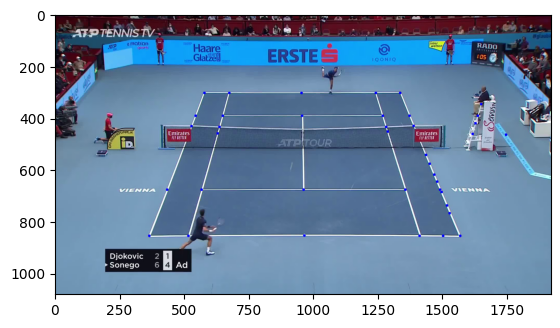

In [16]:
plt.imshow(image)
plt.show()